In [1]:
#Improving Previous Model Accuracy

In [67]:
import os
import zipfile
import requests
import torchvision
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from typing import Dict, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path= Path("Food/")
image_path= data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exist.")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    

with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('downloading data')
    f.write(request.content)
        
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print('Unzipping food data')
    zip_ref.extractall(image_path)

Food\pizza_steak_sushi already exist.
downloading data
Unzipping food data


In [4]:
#removing zip file
os.remove(data_path / "pizza_steak_sushi.zip")

In [5]:
#training and testing pth
train_dir=image_path/'train'
test_dir=image_path/'test'

In [6]:
train_dir, test_dir

(WindowsPath('Food/pizza_steak_sushi/train'),
 WindowsPath('Food/pizza_steak_sushi/test'))

In [7]:
#import datasets, transform
data_transform=transforms.Compose([transforms.Resize((64, 64)),
                                   transforms.ToTensor()])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Food\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 80
     Root location: Food\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [8]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [9]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [10]:
len(train_data), len(test_data)

(225, 80)

In [11]:
# Turning Train and testing data into dataloaders
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=1,
                             num_workers=4,
                             shuffle=True)

test_dataloader= DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=4,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27ff2720ec0>,
 <torch.utils.data.dataloader.DataLoader at 0x27fd6498550>)

In [12]:
#checking
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [13]:
#Making Model

In [14]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_unit:int, output_shape:int)-> None:
        super().__init__()
        self.conv_bloc_1=nn.Sequential(nn.Conv2d(in_channels=input_shape,out_channels=hidden_unit,kernel_size=3, stride=1, padding=0),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=0),
                                       nn.ReLU(),
                                       nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv_bloc_2=nn.Sequential(nn.Conv2d(hidden_unit, hidden_unit, kernel_size=3, padding=0),
                                       nn.ReLU(),
                                       nn.Conv2d(hidden_unit, hidden_unit, kernel_size=3, padding=0),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2))
        
        self.classifier =nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=hidden_unit*13*13,out_features=output_shape)) #Hardcoded
        
    def forward(self, x:torch.tensor):
        x=self.conv_bloc_1(x)
        x=self.conv_bloc_2(x)
        x=self.classifier(x)
        return x

In [15]:
torch.manual_seed(42)
model_1=TinyVGG(input_shape=3, hidden_unit=10, output_shape=len(train_data.classes))
model_1

TinyVGG(
  (conv_bloc_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_bloc_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [16]:
# To test our model

In [17]:
img_batch, batch_label=next(iter(train_dataloader))
img_single, label_single=img_batch[0].unsqueeze(dim=0), batch_label[0]
img_single.shape

torch.Size([1, 3, 64, 64])

In [18]:
model_1.eval()
with torch.inference_mode():
    pred=model_1(img_single)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]])

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]])

Output prediction label:
tensor([0])

Actual label:
0


In [19]:
#making train

In [20]:
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer)-> Tuple[float, float]:
    model.train()
    train_loss, train_acc=0,0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        loss=loss_fn(y_pred, y)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjusting metrics to get avg loss and accuracy
    train_loss= train_loss/len(dataloader)
    train_acc= train_acc/len(dataloader)

    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            test_pred_logits = model(X)

            loss=loss_fn(test_pred_logits, y)
            test_loss+=loss.item()

            test_pred_labels= test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)
    return test_loss, test_acc
        

In [22]:
from typing import Dict
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int)-> Dict[str, list[float]]:
    # Creating Dictionary to store values
    results={"train_loss": [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}
    
    for epoch in range(epochs):
        train_loss, train_acc= train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
                                          
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
                                          
        print(f"Epochs : {epoch+1} | "
              f"Train_loss : {train_loss :4f} | "
              f"Train_acc : {train_acc:.4f} | "
              f"Test_loss : {test_loss:.4f} | "
              f"Test_acc : {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
                                          
    return results                                        

In [23]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_unit=64,
                  output_shape=len(train_data.classes))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=1e-4)


results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=15)

Epochs : 1 | Train_loss : 1.110057 | Train_acc : 0.4356 | Test_loss : 1.0576 | Test_acc : 0.4625
Epochs : 2 | Train_loss : 1.031615 | Train_acc : 0.5067 | Test_loss : 0.9954 | Test_acc : 0.4625
Epochs : 3 | Train_loss : 0.927079 | Train_acc : 0.6044 | Test_loss : 1.1414 | Test_acc : 0.4250
Epochs : 4 | Train_loss : 0.893553 | Train_acc : 0.6089 | Test_loss : 1.0037 | Test_acc : 0.5000
Epochs : 5 | Train_loss : 0.784474 | Train_acc : 0.6844 | Test_loss : 1.0178 | Test_acc : 0.4875
Epochs : 6 | Train_loss : 1.010224 | Train_acc : 0.5556 | Test_loss : 1.1000 | Test_acc : 0.3500
Epochs : 7 | Train_loss : 1.006519 | Train_acc : 0.5689 | Test_loss : 1.2052 | Test_acc : 0.5000
Epochs : 8 | Train_loss : 0.842864 | Train_acc : 0.6800 | Test_loss : 1.0428 | Test_acc : 0.5000
Epochs : 9 | Train_loss : 0.771160 | Train_acc : 0.6578 | Test_loss : 1.1351 | Test_acc : 0.4875
Epochs : 10 | Train_loss : 0.672285 | Train_acc : 0.7556 | Test_loss : 1.1213 | Test_acc : 0.5375
Epochs : 11 | Train_loss : 0.

In [24]:
#Making a new model

In [58]:
train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor()])

In [59]:
class ImprovedVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self._get_flattened_size((3, 64, 64), hidden_units), 512)
        self.fc2 = nn.Linear(512, output_shape)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def _get_flattened_size(self, input_shape, hidden_units):
        """ Forward pass a dummy tensor to calculate the flattened size dynamically. """
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv_block_1(x)
            x = self.conv_block_2(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [60]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01, weight_decay=1e-4)

In [61]:
from torch.utils.data.sampler import WeightedRandomSampler


class_counts = torch.bincount(torch.tensor(train_data.targets))
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_data.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=sampler)

In [62]:
torch.manual_seed(42)
model_2 = ImprovedVGG(input_shape=3, hidden_units=64, output_shape=len(train_data.classes))

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

results_2 = train(model_2,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optimizer,
                epochs=10)

Epochs : 1 | Train_loss : 38.116283 | Train_acc : 0.3422 | Test_loss : 1.0938 | Test_acc : 0.3875
Epochs : 2 | Train_loss : 1.119109 | Train_acc : 0.2267 | Test_loss : 1.1083 | Test_acc : 0.2625
Epochs : 3 | Train_loss : 1.110185 | Train_acc : 0.3556 | Test_loss : 1.1084 | Test_acc : 0.3500
Epochs : 4 | Train_loss : 1.114920 | Train_acc : 0.2978 | Test_loss : 1.1019 | Test_acc : 0.3500
Epochs : 5 | Train_loss : 1.105621 | Train_acc : 0.2800 | Test_loss : 1.1036 | Test_acc : 0.3500
Epochs : 6 | Train_loss : 1.112897 | Train_acc : 0.3467 | Test_loss : 1.1100 | Test_acc : 0.2625
Epochs : 7 | Train_loss : 1.222300 | Train_acc : 0.3778 | Test_loss : 27.2372 | Test_acc : 0.2625
Epochs : 8 | Train_loss : 1.334374 | Train_acc : 0.3156 | Test_loss : 1.0971 | Test_acc : 0.3500
Epochs : 9 | Train_loss : 1.111327 | Train_acc : 0.3200 | Test_loss : 1.0947 | Test_acc : 0.3500
Epochs : 10 | Train_loss : 1.330876 | Train_acc : 0.3289 | Test_loss : 1.1150 | Test_acc : 0.3500


In [63]:
import pandas as pd
model_1_df = pd.DataFrame(results)
model_2_df = pd.DataFrame(results_2)

In [64]:
model_1_d

,train_loss,train_acc,test_loss,test_acc
0,1.110057,0.435556,1.057576,0.4625
1,1.031615,0.506667,0.995352,0.4625
2,0.927079,0.604444,1.141395,0.4250
3,0.893553,0.608889,1.003670,0.5000
4,0.784474,0.684444,1.017831,0.4875
5,1.010224,0.555556,1.099974,0.3500
6,1.006519,0.568889,1.205216,0.5000
7,0.842864,0.680000,1.042808,0.5000
8,0.771160,0.657778,1.135122,0.4875
9,0.672285,0.755556,1.121269,0.5375


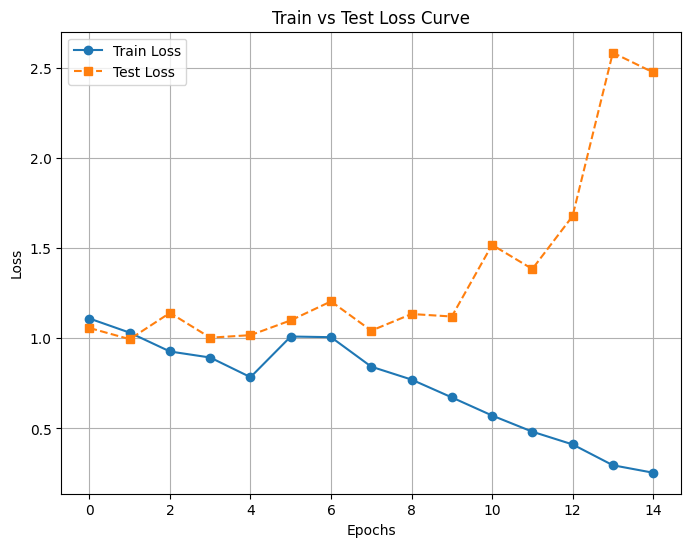

In [66]:
model_1_df = pd.DataFrame(results)

plt.figure(figsize=(8,6))
plt.plot(model_1_df["train_loss"], label="Train Loss", marker="o", linestyle="-")
plt.plot(model_1_df["test_loss"], label="Test Loss", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
